Current event count: 0
No events found. Re-adding core events...
Successfully added events and impact links.


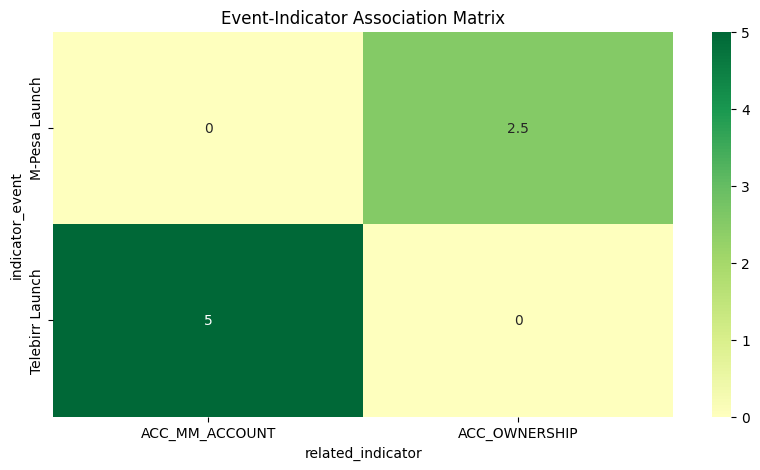

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv('../data/raw/ethiopia_fi_unified_data.csv')

# 2. EMERGENCY CHECK: Do we have events?
event_count = len(df[df['record_type'] == 'event'])
print(f"Current event count: {event_count}")

if event_count == 0:
    print("No events found. Re-adding core events...")
    core_events = [
        {'record_type': 'event', 'pillar': 'USAGE', 'indicator': 'Telebirr Launch', 'observation_date': '2021-05-11'},
        {'record_type': 'event', 'pillar': 'ACCESS', 'indicator': 'M-Pesa Launch', 'observation_date': '2023-08-15'},
        {'record_type': 'event', 'pillar': 'ACCESS', 'indicator': 'Safaricom Entry', 'observation_date': '2022-10-06'}
    ]
    df = pd.concat([df, pd.DataFrame(core_events)], ignore_index=True)

# 3. Locate Indices safely (avoiding the IndexError)
def get_idx(keyword):
    matches = df[df['indicator'].str.contains(keyword, na=False, case=False)]
    return matches.index[0] if not matches.empty else None

tele_idx = get_idx('Telebirr')
mpesa_idx = get_idx('M-Pesa')

# 4. Add Impact Links (The rules for your model)
if tele_idx is not None and mpesa_idx is not None:
    new_links = [
        {'record_type': 'impact_link', 'parent_id': tele_idx, 'related_indicator': 'ACC_MM_ACCOUNT', 
         'impact_direction': 'positive', 'impact_magnitude': 'high', 'lag_months': 6},
        {'record_type': 'impact_link', 'parent_id': mpesa_idx, 'related_indicator': 'ACC_OWNERSHIP', 
         'impact_direction': 'positive', 'impact_magnitude': 'medium', 'lag_months': 12}
    ]
    df = pd.concat([df, pd.DataFrame(new_links)], ignore_index=True)
    df.to_csv('../data/raw/ethiopia_fi_unified_data.csv', index=False)
    print("Successfully added events and impact links.")
else:
    print("Error: Could not find or create events.")

# 5. Build the Association Matrix
events = df[df['record_type'] == 'event']
links = df[df['record_type'] == 'impact_link']

# Merge and create coefficients
impact_df = links.merge(events[['indicator']], left_on='parent_id', right_index=True, suffixes=('_impact', '_event'))
mag_map = {'high': 5.0, 'medium': 2.5, 'low': 1.0}
dir_map = {'positive': 1, 'negative': -1}
impact_df['coefficient'] = impact_df['impact_magnitude'].map(mag_map) * impact_df['impact_direction'].map(dir_map)

# Pivot and Plot
association_matrix = impact_df.pivot_table(index='indicator_event', columns='related_indicator', values='coefficient').fillna(0)
plt.figure(figsize=(10, 5))
sns.heatmap(association_matrix, annot=True, cmap='RdYlGn', center=0)
plt.title("Event-Indicator Association Matrix")
plt.savefig('../reports/figures/association_matrix.png')
plt.show()